## Graph Partitioning

I made a graph partitioning algorithm to help create subgraphs that
(1) has the least connecting edges
(2) has a similar internal node label and graph structure

In [5]:
from collections import defaultdict, deque
import copy
import numpy as np
import itertools

### Functions about connected components

In [6]:
def component_nodes(node, adj_list):
    queue = deque([node])
    nodes_in_component = set()

    while queue:
        current_node = queue.popleft()
        nodes_in_component.add(current_node)
        
        for neighbour in adj_list[current_node]:
            if neighbour not in nodes_in_component:
                queue.append(neighbour)

    return nodes_in_component
    
def get_all_connected_components(adj_list):
    connected_components = []
    visited = set()
    isolated_nodes = []
    
    for node in range(len(adj_list)):
        if node not in visited:
            cc = component_nodes(node, adj_list)
            if len(cc) == 1: # Isolated nodes
                isolated_nodes.append(next(iter(cc)))
            else:
                connected_components.append(cc)
            visited |= cc

    return connected_components, isolated_nodes

def connect_graphs(splittable_cc, adj_list):
    '''Link all the connected components.'''
    synthetic_edges = []
    for i, cc in enumerate(splittable_cc):
        if i == 0:
            last = list(cc)[-1] # record the last element for linking 
        else:
            # Create an undirected edge that connects the last element of previous cc and the first element of current cc
            first = list(cc)[0]
            adj_list[first].append(last)
            adj_list[last].append(first)
            synthetic_edges.append((first, last))
            synthetic_edges.append((last, first))
            last = list(cc)[-1]

    return adj_list, synthetic_edges

def count_edges(adj_list, nodes, synthetic_edges):
    '''Count the number of edges in a subgraph given their nodes.'''
    edge_count = 0
    # Convert adjacency list to a set of undirected edges for quick lookup
    edges_set = set()
    
    # Create the set of edges
    for node, neighbors in enumerate(adj_list):
        for neighbor in neighbors:
            if (node, neighbor) not in synthetic_edges:
                # Store edges as frozensets to handle undirected edges (order doesn't matter)
                edges_set.add(frozenset([node, neighbor]))

    # Now check each pair of nodes
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            node1, node2 = nodes[i], nodes[j]
            if frozenset([node1, node2]) in edges_set:
                edge_count += 1
                
    return edge_count

### Functions for Finding roots (by comparing shortest path of all pairs of nodes)

In [15]:
def bfs_shortest_paths(adj_list, start):
    """Computes shortest paths from `start` node to all others (except isolated nodes) using BFS."""    
    n = len(adj_list)
    dist = [float('inf')] * n
    dist[start] = 0
    queue = deque([start])

    while queue:
        node = queue.popleft()
        for neighbor in adj_list[node]:
            if dist[neighbor] == float('inf'):  # Unvisited
                dist[neighbor] = dist[node] + 1
                queue.append(neighbor)

    return dist

def all_pairs_shortest_paths(adj_list, isolated_nodes=[]):
    """Computes shortest paths between all pairs using BFS (for unweighted graphs)."""
    return [bfs_shortest_paths(adj_list, node) if node not in isolated_nodes else None for node in range(len(adj_list))]

def find_k_furthest_nodes(adj_list, k, isolated_nodes=[]):
    """Finds k nodes that are maximally distant from each other."""
    dist = all_pairs_shortest_paths(adj_list, isolated_nodes)
    n = len(adj_list)

    # Step 1: Find the two most distant nodes (graph diameter endpoints)
    max_dist = -1
    best_pair = None
    valid_nodes = [node for node in range(n) if node not in isolated_nodes]

    for u, v in itertools.combinations(valid_nodes, 2):
        if dist[u][v] > max_dist:
            max_dist = dist[u][v]
            best_pair = (u, v)

    selected = list(best_pair)  # Start with the two furthest nodes

    # Step 2: Iteratively select the node maximizing the minimum distance to the current set
    while len(selected) < k and len(selected) < len(valid_nodes):
        best_node = None
        max_min_dist = -1

        for node in valid_nodes:
            if node in selected:
                continue
            min_dist = min(dist[node][s] for s in selected)  # Distance to closest selected node
            if min_dist > max_min_dist:
                max_min_dist = min_dist
                best_node = node

        selected.append(best_node)

    return selected

### Function for Finding Roots (by giving a start node and get the K-1 furthest node from each other)

In [15]:
def bfs_longest_path(adj_list, start):
    """Find the farthest node from start using BFS and return the node and distances."""
    queue = deque([start])
    distances = {start: 0}
    farthest_node = start

    while queue:
        node = queue.popleft()
        for neighbor in adj_list[node]:
            if neighbor not in distances:  # Not visited
                distances[neighbor] = distances[node] + 1
                queue.append(neighbor)
                farthest_node = neighbor  # Keep track of the last (farthest) node

    return farthest_node, distances

def get_k_furthest_nodes(adj_list, start, K):
    """Find K nodes that are maximally separated from each other, starting from a given node."""
    if K > len(adj_list):
        raise ValueError("K is larger than the number of available nodes.")
    
    if isinstance(start, set):
        start = next(iter(start))
        print("start is", start)

    # Step 1: Find the farthest node from the start
    first_farthest, _ = bfs_longest_path(adj_list, start)
    selected_nodes = [start, first_farthest]

    # Step 2: Iteratively find the next farthest nodes
    for _ in range(K - 2):
        max_dist_node = None
        max_min_distance = -1

        for candidate in range(len(adj_list)):  # Check all possible nodes
            if candidate in selected_nodes:
                continue  # Skip already selected nodes
            
            # Compute the shortest distance to any of the already selected nodes
            _, distances = bfs_longest_path(adj_list, candidate)
            min_distance = min(distances[n] for n in selected_nodes if n in distances)

            if min_distance > max_min_distance:
                max_min_distance = min_distance
                max_dist_node = candidate

        if max_dist_node is not None:
            selected_nodes.append(max_dist_node)

    return selected_nodes

### Function for Resolving Conflicting Nodes

In [16]:
def resolve_conflicts(node, adj_list, subgraph_allocated, previous_level_subgraph, synthetic_edges, node_labels):
    best_subgraph, best_subgraph_score = None, 0
    for subgraph in subgraph_allocated: # compute score for given root
        number_subgraph_edges = count_edges(adj_list, list(previous_level_subgraph[subgraph] - {node}), synthetic_edges)
        number_neighbours = len(set(adj_list[node])&previous_level_subgraph[subgraph])
        
        if node_labels is not None: # Add labels classification score
            alpha, beta = 0.1, 0.1
            current_subgraph = np.array(list(previous_level_subgraph[subgraph] - {node}))
            node_label_array = np.array(node_labels)
            label_counts = np.bincount(node_label_array[current_subgraph], minlength=max(node_label_array)+1)

            number_unique_labels = np.count_nonzero(label_counts)
            label_diversity_score = alpha / (1+number_unique_labels)

            label_occurrence = label_counts[node_labels[node]]
            occurrence_score = beta / (1+label_occurrence)
            print("current subgraph", current_subgraph)
            print("label set", set(node_label_array[current_subgraph]))
            node_score = label_diversity_score + occurrence_score
            print("Subgraph", subgraph, "label diversity =", label_diversity_score, "label occurrence =", occurrence_score, "node_score=", node_score)
        else:
            node_score = 0

        cut_edge_score = (1/(1 + len(adj_list[node]) - number_neighbours))
        edge_balanced_score = (1/(1+number_subgraph_edges))
        score = cut_edge_score + edge_balanced_score + node_score
        print("Subgraph", subgraph, "cut edge score" , cut_edge_score, "edge balanced score", edge_balanced_score, "edge_score", cut_edge_score+edge_balanced_score)

        if score > best_subgraph_score:
            best_subgraph = subgraph
            best_subgraph_score = score

    return best_subgraph

## The Main Function

In [ ]:
def our_gpa(adj_list, node_labels=None, K=2):
    '''
    A function that splits the graph into K subgraphs which:

    1) Minimizes cut edges between subgraphs
    2) Balance Edge Counts of each subgraph
    3) Spread Node Labels evenly

    Inputs:
    1) adj_list -> List[List[]]: Adjacency List of the graph (undirected) where the ith indexed list stores the one-hop neighbours of node i 
    2) node_labels -> List[]: Node Labels of all nodes (Default as None)
    3) K -> int: Number of subgraphs

    Outputs:
    List[] -> Subgraph assignment of each node 
    '''
    previous_level_subgraph = defaultdict(set)
    node_to_allocated_subgraph = defaultdict(set)
    nodes_visited = set()

    # Identify all connected components
    connected_components, isolated_nodes = get_all_connected_components(adj_list)
    adj_list, synthetic_edges = connect_graphs(connected_components, adj_list)

    # Allocate all isolated nodes first
    for i, iso in enumerate(isolated_nodes):
        node_to_allocated_subgraph[iso] = {i%K}

    roots = find_k_furthest_nodes(adj_list, K, isolated_nodes=isolated_nodes)
    print("Roots", roots)

    # BFS outward from each root node
    level_queue = [(root_node, i) for i, root_node in enumerate(roots)]

    while level_queue:
        nodes_visited_this_level = set()

        for node, assign in level_queue:
            node_to_allocated_subgraph[node].add(assign)
            nodes_visited_this_level.add(node)
            nodes_visited.add((node, assign))

        for node, subgraph_allocated in node_to_allocated_subgraph.items(): # First allocate the unconflicted nodes
            if len(subgraph_allocated) == 1:
                previous_level_subgraph[next(iter(subgraph_allocated))].add(node)

        # Resolve conflicts with your weighting scheme
        for node, subgraph_allocated in node_to_allocated_subgraph.items():
            if len(subgraph_allocated) > 1: # conflict case
                print("node", node)
                best_subgraph = resolve_conflicts(node, adj_list, subgraph_allocated, previous_level_subgraph, synthetic_edges, node_labels)
                node_to_allocated_subgraph[node] &= {best_subgraph}
                print("node", node, "allocated to", best_subgraph)
        
        # Update previous_level_subgraph & consider nodes for next level
        for node, subgraph_allocated in node_to_allocated_subgraph.items():
            previous_level_subgraph[next(iter(subgraph_allocated))].add(node)

        # Consider nodes to visit next :)
        next_level = []
        for node in nodes_visited_this_level:
            node_subgraph = next(iter(node_to_allocated_subgraph[node]))
            for neighbour in adj_list[node]:
                if neighbour not in previous_level_subgraph[node_subgraph] and (neighbour, node_subgraph) not in nodes_visited and neighbour not in roots:
                    next_level.append([neighbour, node_subgraph])

        level_queue = copy.deepcopy(next_level)
        
    return [node_to_allocated_subgraph[i].pop() for i in range(len(node_to_allocated_subgraph))]


In [18]:
adjacencyList1 = [[1,3],[0,2,3,5],[1,3],[0,1,2,4],[3,8],[1,6],[5,7,8],[6,8],[4,6,7]]
adjacencyList2 = [[4],[3],[6,7],[1,4,5,6,9],[0,3,5,6,8],[3,4,8],[2,3,4,7],[2,6],[4,5],[3]]
adjacencyList3 = [[4,5,8,9,7,2],[6,4,7],[0,9,3],[2,7],[1,8,0,5],[4,0,9],[1],[1,8,0,9,3],[4,0,7],[0,5,2,7]]
adjacencyList4 = [[4,2,5,7],[],[0,3],[2,7,8],[0,8],[0],[],[0,3,8],[3,4,7],[]] # for isolated node testing
adjacencyList5 = [[10],[4,9,14],[3,7,14],[2,12],[1,9,13],[12],[10],[2,8],[7,13],[1,4,10],[0,6,9,14],[12,14],[11,3,5],[4,8],[1,2,10,11]] # for 3 clients testing
adjacencyList6 = [[10],[4,9,14],[3,7],[2,12],[1,9],[12],[10],[2,8],[7,13],[1,4],[0,6],[12],[11,3,5],[8],[1]] # for connected components testing

node_label1 = [3,3,2,3,2,1,1,1,1]
node_label2 = [1,1,0,1,2,2,0,1,1,0]
node_label34 = [2,1,3,1,0,1,3,2,1,1]
node_label56 = [2,0,2,3,3,2,1,3,1,2,1,3,2,1,3]

our_gpa(adjacencyList4, node_label34, K=2)

Roots [3, 5]
node 2
current subgraph [1 3 7 8 9]
label set {1, 2}
Subgraph 0 label diversity = 0.03333333333333333 label occurrence = 0.1 node_score= 0.13333333333333333
Subgraph 0 cut edge score 0.5 edge balanced score 0.25 edge_score 0.75
current subgraph [0 5 6]
label set {1, 2, 3}
Subgraph 1 label diversity = 0.025 label occurrence = 0.05 node_score= 0.07500000000000001
Subgraph 1 cut edge score 0.5 edge balanced score 0.5 edge_score 1.0
node 2 allocated to 1
node 7
current subgraph [1 2 3 8 9]
label set {1, 3}
Subgraph 0 label diversity = 0.03333333333333333 label occurrence = 0.1 node_score= 0.13333333333333333
Subgraph 0 cut edge score 0.5 edge balanced score 0.3333333333333333 edge_score 0.8333333333333333
current subgraph [0 5 6]
label set {1, 2, 3}
Subgraph 1 label diversity = 0.025 label occurrence = 0.05 node_score= 0.07500000000000001
Subgraph 1 cut edge score 0.3333333333333333 edge balanced score 0.5 edge_score 0.8333333333333333
node 7 allocated to 0
node 0
current subg

[1, 0, 1, 0, 1, 1, 1, 0, 0, 0]

In [27]:
import torch 
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

def generate_example_graph():
    """ Generate a small example graph. """
    num_edges = 20
    edge_index = torch.zeros((2, num_edges), dtype=torch.long)
    for i in range(20):
        edge_index[:, i] = torch.randperm(10)[:2]  # Pick 2 unique numbers from 0-9
    num_nodes = 10
    node_labels = torch.randint(0, 4, (num_nodes,))  # Assign random labels
    return Data(edge_index=edge_index, num_nodes=num_nodes, y=node_labels)

def visualize_graph(data):
    """ Convert PyG Data to NetworkX and visualize the graph. """
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    node_labels = {i: [i, data.y[i].item()] for i in range(len(data.y))}
    
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    plt.title("Graph Visualization")
    plt.show()

def edge_index_to_adj_list(edge_index, num_nodes):
    adj_list = [[] for _ in range(num_nodes)]  # Initialize adjacency list
    for src, dst in zip(edge_index[0], edge_index[1]):  # Iterate over edges
        adj_list[src.item()].append(dst.item())
        adj_list[dst.item()].append(src.item()) # both direction

    return adj_list

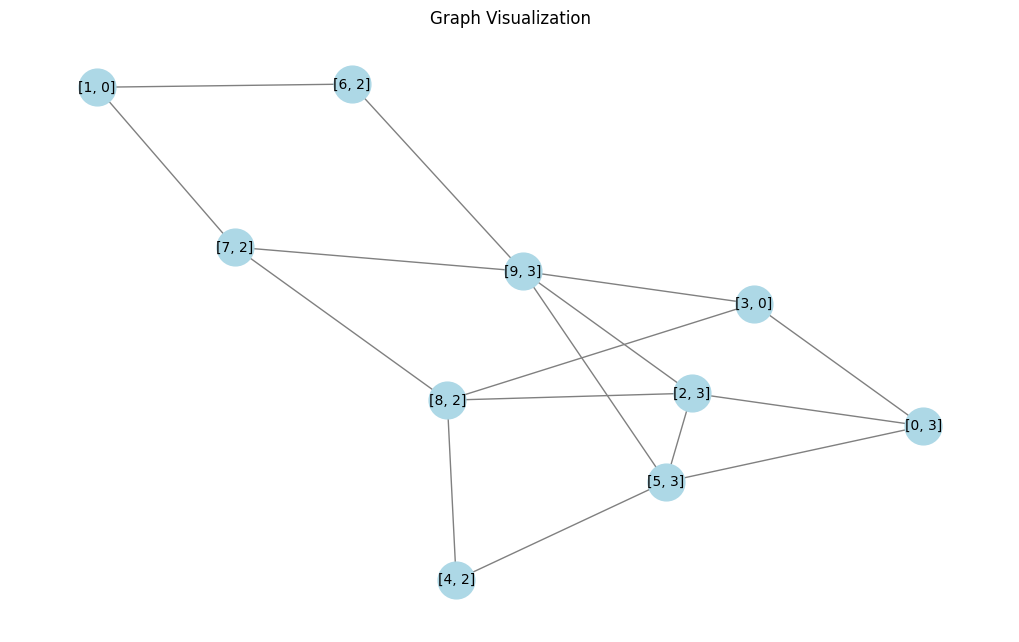

In [28]:
graph_data = generate_example_graph()
visualize_graph(graph_data)

In [30]:
import metis
_, partitioning_labels = metis.part_graph(adjacencyList4, 2)

print(partitioning_labels)

[0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
